In [1]:
import pandas as pd
from lmfit import Parameters, fit_report, minimize
import matplotlib.pyplot as plt 
import numpy as np
import uncertainties as un

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'pgf.preamble': r'\usepackage{amsmath}'})

In [2]:
# orden:
# 0: sin bloque/ solo aire.
# 1: parafina 1 bloque.
# 2: parafina 2 bloque.
# 3: parafina 3 bloque.

parafina = []
parafina.append(pd.read_csv("parafina_aire.csv"))
for i in range(3):
    parafina.append(pd.read_csv(f"parafina_{i+1}.csv"))
parafina[0]

,canal,cuentas
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
1019,1019,0
1020,1020,0
1021,1021,0
1022,1022,0


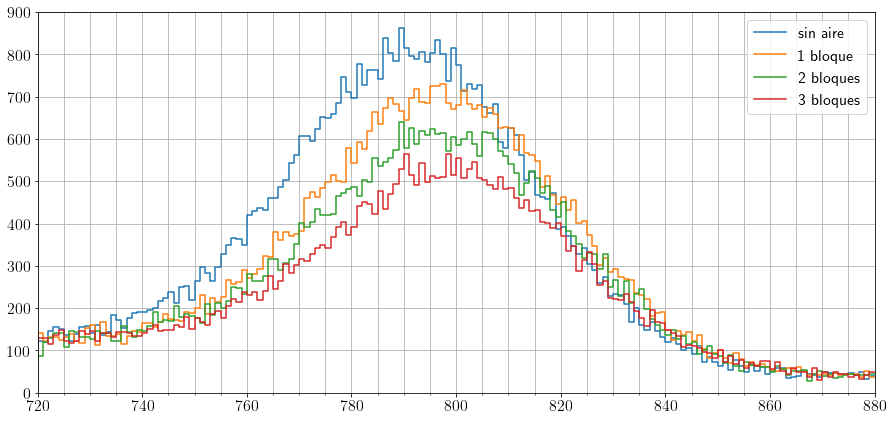

In [3]:
lim_inf = 720
lim_sup = 881
x = []
y = []
labels = ["sin aire", "1 bloque", "2 bloques", "3 bloques"]
fig, ax = plt.subplots(figsize = (15,7))
for i in range(4):
    x.append(parafina[i].iloc[lim_inf:lim_sup,0])
    y.append(parafina[i].iloc[lim_inf:lim_sup,1])
    ax.step(x[i], y[i], label = labels[i])
ax.tick_params(axis = "both", which = "major", labelsize = 16)
ax.grid(True, which = "both")
ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
ax.set_ylim(0, 900)
ax.set_xlim(lim_inf, lim_sup-1)
ax.legend(fontsize = 16)

x = np.array(x)
y = np.array(y)


In [4]:
μ = np.array([800,797,795,790])
σ = np.array([(μ[0] - 845)/3,
             (μ[1] - 845)/3,
             (μ[2] - 845)/3,
             (μ[3] - 845)/3,])
b1 = []
for i in range(4):
    b1.append((y[i,0]-y[i,-1])/(x[i,0]-x[i,-1]))
b1 = np.array(b1)
b0 = []
for i in range(4):
    b0.append(y[i,0]-b1[i]*(x[i,0]-μ[i]))
M = np.array([550-b0[0],
             610-b0[1],
             735-b0[2],
             810-b0[3]])


In [5]:
exp_gaussian  = lambda X, mu, sigma, m, B0, B1: m*np.exp(-(1/2)*((X-mu)/sigma)**2) + B0 + B1*(X-mu)

def residual_gauss(pars, X, data):
    """Model a decaying sine wave and subtract data."""
    vals = pars.valuesdict()
    m = vals['M']
    mu = vals['μ']
    sigma = vals['σ']
    B0 = vals['b0']
    B1 = vals['b1']
    
    model = m*np.exp(-(1/2)*((X-mu)/sigma)**2) + B0 + B1*(X-mu)
    resids = model-data
    # weighted = np.sqrt(resids ** 2/sig**2)
    return resids

fit_params = []
minim = []
out = []



for i in range(4):
    fit_params.append(Parameters())
    fit_params[i].add('M', value= M[i])
    fit_params[i].add('μ', value= μ[i])
    fit_params[i].add('σ', value= σ[i])
    fit_params[i].add('b0', value = b0[i])
    fit_params[i].add('b1', value= b1[i])
    minim.append(minimize(residual_gauss, fit_params[i], args=(x[i],), kws={'data': y[i]}))
    out.append(minim[i].params)
    
M = []
μ = []
σ = []
b0 = []
b1 = []    

for i in range(4):
    M.append(un.ufloat(out[i]["M"].value, out[i]["M"].stderr))
    μ.append(un.ufloat(out[i]["μ"].value, out[i]["μ"].stderr))
    σ.append(np.abs(un.ufloat(out[i]["σ"].value, out[i]["σ"].stderr)))
    b0.append(un.ufloat(out[i]["b0"].value, out[i]["b0"].stderr))
    b1.append(un.ufloat(out[i]["b1"].value, out[i]["b1"].stderr))
for el in M: print(el)
print("\n")
for el in σ: print(el)
print("\n")
for el in μ: print(el)

721+/-4
624+/-4
532+/-4
443.5+/-3.4


22.79+/-0.19
23.15+/-0.19
23.42+/-0.26
23.09+/-0.25


792.17+/-0.15
797.96+/-0.15
798.73+/-0.21
799.61+/-0.20


In [ ]:
xe = np.linspace(lim_inf, lim_sup, 1000)
fig, ax = plt.subplots(figsize = (10,7))
for i in range(4):
    ax.step(x[i], y[i], label = "datos"+labels[i])
    ax.plot(xe, exp_gaussian(xe, μ[i].nominal_value, σ[i].nominal_value, M[i].nominal_value, b0[i].nominal_value, b1[i].nominal_value), label = "ajuste"+labels[i])
    ax.tick_params(axis = "both", which = "major", labelsize = 16)
    ax.grid(True, which = "both")
    ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
    ax.set_ylim(0, 900)
    ax.set_xlim(lim_inf, lim_sup-1)
    ax.set_ylabel(r"$I_\gamma$ (cuentas/canal)", fontsize = 20)
    ax.set_xlabel(r"$E_\gamma$ (canal)", fontsize = 20)
    ax.legend(fontsize = 16)
    fig.savefig("parafina_1_bloque.pdf", format = "pdf")
plt.show()

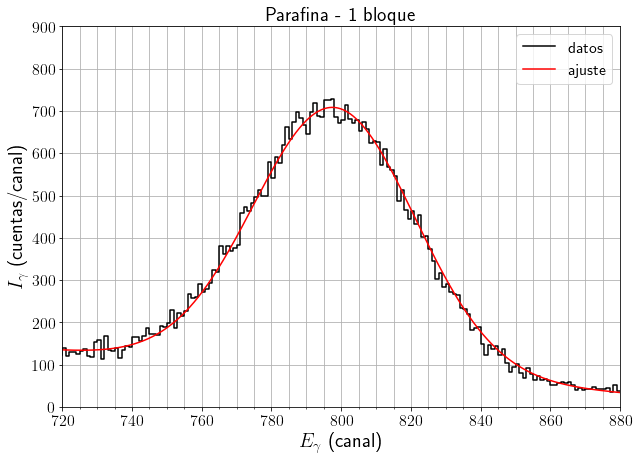

[22.78551655906109+/-0.18767053981185491, 23.14753637189156+/-0.19062809787176624, 23.419080920940516+/-0.2568103415145417, 23.08938299662906+/-0.2502520237773428]


In [7]:
xe = np.linspace(lim_inf, lim_sup, 1000)
fig, ax = plt.subplots(figsize = (10,7))
i=1
ax.step(x[i], y[i], label = "datos", color = "k")
ax.plot(xe, exp_gaussian(xe, μ[i].nominal_value, σ[i].nominal_value, M[i].nominal_value, b0[i].nominal_value, b1[i].nominal_value), label = "ajuste", color = "r")
ax.tick_params(axis = "both", which = "major", labelsize = 16)
ax.grid(True, which = "both")
ax.set_title("Parafina - "+labels[i], fontsize = 20)
ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
ax.set_ylim(0, 900)
ax.set_xlim(lim_inf, lim_sup-1)
ax.set_ylabel(r"$I_\gamma$ (cuentas/canal)", fontsize = 20)
ax.set_xlabel(r"$E_\gamma$ (canal)", fontsize = 20)
ax.legend(fontsize = 16)
fig.savefig("parafina_1_bloque.pdf", format = "pdf")
plt.show()
print(σ)

In [8]:
from uncertainties import unumpy
I = []
for i in range(4):
    I.append(np.sqrt(2.*np.pi)*M[i]*σ[i])
I = np.array(I)
for el in I: print(el)

(4.12+/-0.04)e+04
(3.62+/-0.04)e+04
(3.13+/-0.04)e+04
(2.567+/-0.034)e+04


0.005357459282154616


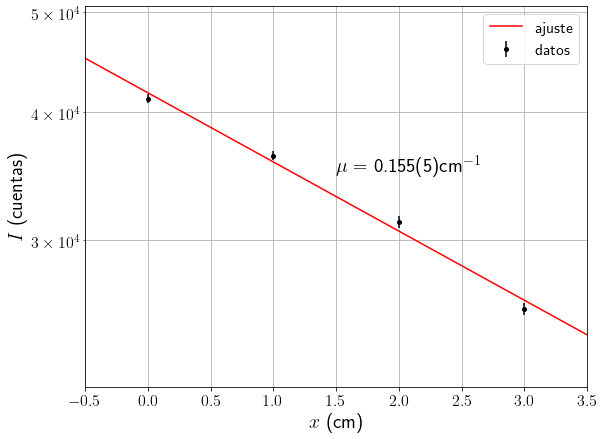

In [9]:
from matplotlib import scale

width = np.array([0,1,2,3])

I_nom = unumpy.nominal_values(I)
I_stderr = unumpy.std_devs(I)

exp_aten = lambda X, i0, mu: i0*np.exp(-mu*X)  

def residual_aten(pars, X, data, sig):
    vals = pars.valuesdict()
    i0 = vals["I0"]
    mu = vals["μ_aten"]
    model = exp_aten(X, i0, mu)
    resids = model-data
    xi_sqr = resids**2/sig**2
    return xi_sqr


mu_aten_in = (np.log(I_nom[0])-np.log(I_nom[-1]))/(width[0]-width[-1])

fit_params = Parameters()
fit_params.add("I0", value = 4e4)
fit_params.add("μ_aten", value = mu_aten_in)
minim = minimize(residual_aten, fit_params, args=(width,), kws={'data': I_nom, "sig": I_stderr})
out = minim.params

xe = np.linspace(-1,4,1000)
I0 = out["I0"].value
μ_aten = out["μ_aten"].value
μ_aten_stderr = out["μ_aten"].stderr

fig, ax = plt.subplots(figsize = (9,7))
ax.errorbar(width, I_nom, I_stderr, fmt = "o", color = "k", markersize = 4, label = "datos")
ax.plot(xe, exp_aten(xe, I0, μ_aten), color = "r", label = "ajuste")
ax.set_yscale("log")
# ax.yaxis.set_minor_locator(plt.MultipleLocator(1000))
ax.set_ylabel(r"$I$ (cuentas)", fontsize = 20)
ax.set_xlabel(r"$x$ (cm)", fontsize = 20)
ax.grid(True, "both")
ax.set_xlim(-0.5,3.5)
ax.tick_params(axis='both',reset=False, which='both', labelsize = 16)
ax.legend(fontsize = 16)
ax.text(1.5, 3.5e4, f"$\mu = $ {μ_aten:0.3f}({5})"+"cm$^{-1}$", fontsize = 20)
fig.savefig("coef_aten.pdf", format = "pdf")
print(μ_aten_stderr)